# 1. **Business Problem**

# 1.1 Description
Social media platforms like Quora, Reddit etc are places to gain and share knowledge—about anything. These platforms connect users across the globe to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

# **Problem Statement**



*   Identify which questions asked on Quora are duplicates of questions that have already been asked.
*   This could be useful to instantly provide answers to questions that have already been answered.
*  We are tasked with predicting whether a pair of questions are duplicates or not.

# 1.2 Real world/Business Objectives and Constraints

1.   The cost of a mis-classification can be very high.
2.   You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3.  No strict latency concerns.
4.   Interpretability is partially important.

# Reading data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
from bs4 import BeautifulSoup
import warnings

import nltk
from nltk.corpus import stopwords
import distance
from wordcloud import WordCloud, STOPWORDS
import os
from os import path
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

In [ ]:
df = pd.read_csv('train/train.csv')
df.shape

(404290, 6)

In [ ]:
n_df = df.sample(30000,random_state=42)
n_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


# Preprocessing




*   Removing HTML Tags
*   Removing Punctuations
*   Performing Stemming
*   Removing Stopwords
*   Expanding Contractions







In [ ]:
def preprocess(q):
  
  # Converting input to lowercase for easier processing
  q = str(q).lower().strip()

  # Replacing symbols with string equivalents (mainly dealing with currencies based questions)
  q = q.replace('%', ' percent')
  q = q.replace('$', ' dollar ')
  q = q.replace('₹', ' rupee ')
  q = q.replace('€', ' euro ')
  q = q.replace('@', ' at ')
    
  # The pattern '[math]' appears around 900 times (with ) in the whole dataset.
  q = q.replace('[math]', '')
    
  # Replacing some common numbers(via observation) with string equivalents
  q = q.replace(',000,000,000 ', 'b ')
  q = q.replace(',000,000 ', 'm ')
  q = q.replace(',000 ', 'k ')
  q = re.sub(r'([0-9]+)000000000', r'\1b', q)
  q = re.sub(r'([0-9]+)000000', r'\1m', q)
  q = re.sub(r'([0-9]+)000', r'\1k', q)
    
  # Expanding contractions
  contractions = { 
  "ain't": "am not",
  "aren't": "are not",
  "can't": "can not",
  "can't've": "can not have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so as",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you would",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
  }

  q_dec = []

  for word in q.split():
    if word in contractions:
      word = contractions[word]
  
    q_dec.append(word)
  
  q=' '.join(q_dec)
  q = ' '.join(q_dec)
  q = q.replace("'ve", " have")
  q = q.replace("n't", " not")
  q = q.replace("'re", " are")
  q = q.replace("'ll", " will")
    
  # Removing HTML tags
  q = BeautifulSoup(q)
  q = q.get_text()
    
  # Removing Punctuations
  ptrn = re.compile('\W')
  q = re.sub(ptrn, ' ', q).strip()

    
  return q

In [ ]:
# Applying preprocess to question1 and question2 features

n_df['question1'] = n_df['question1'].apply(preprocess)
n_df['question2'] = n_df['question2'].apply(preprocess)
n_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0
70497,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0
226567,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1
73186,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1


# Feature Engineering

**Basic Features**

*   ***q1_len*** : Length of question1
*   ***q2_len*** : Length of question2
*   ***q1_num_words*** : Number of words in question1
*   ***q2_num_words*** : Number of words in question2
*   ***Total words*** : Total number of words in the summation of both questions
*   ***common_words*** : Number of common unique words (comparing both questions)
*   ***word share*** : Ratio of number of common unique words and total number of words



In [ ]:
n_df['q1_len'] = n_df['question1'].str.len()
n_df['q2_len'] = n_df['question2'].str.len()
n_df['q1_num_words'] = n_df['question1'].apply(lambda row: len(row.split(" ")))
n_df['q2_num_words'] = n_df['question2'].apply(lambda row: len(row.split(" ")))

def comm_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return len(w1 & w2)

def tot_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return (len(w1) + len(w2))

n_df['Total words'] = n_df.apply(tot_words,axis=1)
n_df['common_words'] = n_df.apply(comm_words,axis = 1)
n_df['word share'] = round(n_df['common_words'] / n_df['Total words'],2)
n_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,Total words,common_words,word share
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,33,33,8,8,16,7,0.44
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,52,50,11,9,20,6,0.30
70497,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0,95,44,17,8,25,2,0.08
226567,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1,43,51,7,9,16,6,0.38
73186,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1,37,28,9,7,16,4,0.25


**Advanced Features**

**Token Features**

*   ***cwc_min*** : Ratio of common unique word count to minimum length of questions 
*   ***cwc_max*** : Ratio of common unique word count to maximum length of questions 
*   ***csc_min*** : Ratio of common stopwords count to minimum length of stop words count of questions
*   ***csc_max*** : Ratio of common stopwords count to maximum length of stop words count of questions
*   ***ctc_min*** : Ratio of common unique tokens count to minimum length of token count of questions
*   ***ctc_max*** : Ratio of common unique tokens count to maximum length of token count of questions
*   ***last_word_eq*** : To check whether last word of both questions are equal
*   ***first_word_eq*** : To check whether first word of both questions are equal
 




In [ ]:
def fetch_t_f(row):
    
  q1 = row['question1']
  q2 = row['question2']

  # To get results upto 4 decimal places  
  safe_div = 0.0001 

  stop_words = stopwords.words("english")
    
  t_f = [0.0]*8
    
  # Converting sentences into tokens  
  q1_tok = q1.split()
  q2_tok = q2.split()
    
  if len(q1_tok) == 0 or len(q2_tok) == 0:
      return t_f

  # Fetching words other than stopwords out of the questions
  q1_words = set([word for word in q1_tok if word not in stop_words])
  q2_words = set([word for word in q2_tok if word not in stop_words])

  # Fetching stopwords out of the questions  
  q1_stops = set([word for word in q1_tok if word in stop_words])
  q2_stops = set([word for word in q2_tok if word in stop_words])
  
  # Fetching common words other than stopwords
  comm_word_count = len(q1_words.intersection(q2_words))

  # Fetching common stopwords
  comm_stop_count = len(q1_stops.intersection(q2_stops))
  
  # Fetching common tokens from the pair
  comm_tok_count = len(set(q1_tok).intersection(set(q2_tok)))
    
  # Defining the token features   
  t_f[0] = comm_word_count / (min(len(q1_words), len(q2_words)) + safe_div)
  t_f[1] = comm_word_count / (max(len(q1_words), len(q2_words)) + safe_div)
  t_f[2] = comm_stop_count / (min(len(q1_stops), len(q2_stops)) + safe_div)
  t_f[3] = comm_stop_count / (max(len(q1_stops), len(q2_stops)) + safe_div)
  t_f[4] = comm_tok_count / (min(len(q1_tok), len(q2_tok)) + safe_div)
  t_f[5] = comm_tok_count / (max(len(q1_tok), len(q2_tok)) + safe_div)

  # Token feature for last word of the pair is same  
  t_f[6] = int(q1_tok[-1] == q2_tok[-1])

  # Token feature for first word of the pair is same
  t_f[7] = int(q1_tok[0] == q2_tok[0])
    
  return t_f

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Merging features into dataframe
t_f = n_df.apply(fetch_t_f, axis=1)

n_df["cwc_min"]       = list(map(lambda x: x[0], t_f))
n_df["cwc_max"]       = list(map(lambda x: x[1], t_f))
n_df["csc_min"]       = list(map(lambda x: x[2], t_f))
n_df["csc_max"]       = list(map(lambda x: x[3], t_f))
n_df["ctc_min"]       = list(map(lambda x: x[4], t_f))
n_df["ctc_max"]       = list(map(lambda x: x[5], t_f))
n_df["last_word_eq"]  = list(map(lambda x: x[6], t_f))
n_df["first_word_eq"] = list(map(lambda x: x[7], t_f))

n_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,common_words,word share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,33,33,8,8,...,7,0.44,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0.0,1.0
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,52,50,11,9,...,6,0.30,0.399992,0.399992,0.999975,0.666656,0.666659,0.545450,0.0,1.0
70497,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0,95,44,17,8,...,2,0.08,0.000000,0.000000,0.499988,0.249997,0.249997,0.124999,0.0,0.0
226567,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1,43,51,7,9,...,6,0.38,0.999975,0.999975,0.666644,0.399992,0.857131,0.666659,0.0,1.0
73186,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1,37,28,9,7,...,4,0.25,0.749981,0.599988,0.333322,0.249994,0.571420,0.444440,0.0,1.0


**Length based features** 
*   ***Abs len diff*** :  Absolute difference between the length (number of words) of two questions
*   ***Mean len*** : Mean length of the two questions (number of words)
*   ***Ratio of longest substr*** : Ratio of the longest substring among the two questions to the length of smaller question





In [ ]:


def fetch_length_features(row):
    
  q1 = row['question1']
  q2 = row['question2']
    
  length_features = [0.0]*3
    
  # Converting the sentence into tokens 
  q1_tok = q1.split()
  q2_tok = q2.split()
    
  if len(q1_tok) == 0 or len(q2_tok) == 0:
       return length_features
  
  #Absolute Length Feature
  length_features[0] = abs(len(q1_tok) - len(q2_tok))

  # Average token length of both questions
  length_features[1] = (len(q1_tok) + len(q2_tok))/2
  
  # Ratio of longest substring
  strs = list(distance.lcsubstrings(q1, q2))
  length_features[2] = len(strs) / (min(len(q1), len(q2)) + 1)  

  return length_features
    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Merging features into dataframe
length_features = n_df.apply(fetch_length_features, axis=1)

n_df['Abs len diff'] = list(map(lambda x: x[0], length_features))
n_df['Mean len'] = list(map(lambda x: x[1], length_features))
n_df['Ratio of longest substr'] = list(map(lambda x: x[2], length_features))
n_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,Abs len diff,Mean len,Ratio of longest substr
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,33,33,8,8,...,0.749981,0.999975,0.999975,0.874989,0.874989,0.0,1.0,0.0,8.0,0.029412
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,52,50,11,9,...,0.399992,0.999975,0.666656,0.666659,0.545450,0.0,1.0,2.0,10.0,0.019608
70497,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0,95,44,17,8,...,0.000000,0.499988,0.249997,0.249997,0.124999,0.0,0.0,8.0,12.0,0.022222
226567,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1,43,51,7,9,...,0.999975,0.666644,0.399992,0.857131,0.666659,0.0,1.0,2.0,8.0,0.022727
73186,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1,37,28,9,7,...,0.599988,0.333322,0.249994,0.571420,0.444440,0.0,1.0,2.0,8.0,0.068966


# Analysis of extracted features

**Word Cloud**

Plotting word clouds for Duplicates as well as non duplicates questions pairs


In [ ]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] ==0 ]

#Converting 2d array of q1 and q2 and flatten the array: like {{1,2}, {3,4}}

p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print("Number of datapoints in question 1 (duplicate pairs) : ", len(p))
print("Number of datapoints in question 0 (non duplicate pairs) : ", len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter= ' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter= ' ', fmt='%s')

Number of datapoints in question 1 (duplicate pairs) :  298526
Number of datapoints in question 0 (non duplicate pairs) :  510054


In [ ]:
#Reading the text file and removing the stopwords
d = path.dirname('/content/train_p.txt')
textp_w = open(path.join(d, 'train_p.txt')).read()
d1 = path.dirname('/content/train_n.txt')
textn_w = open(path.join(d1, 'train_n.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.add("not")

stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
print("Total number of words in duplicate pair questions :", len(textp_w))
print("Total number of words in non duplicate pair questions :", len(textn_w))

Total number of words in duplicate pair questions : 16087608
Total number of words in non duplicate pair questions : 33092288


Word Cloud for Duplicate Question pairs


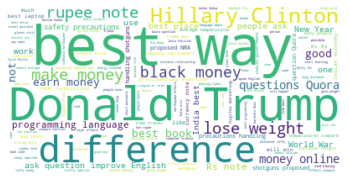

In [ ]:
# Word cloud for duplicate question pairs
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords = stopwords)
#Generation of word cloud
wc.generate(textp_w)
print("Word Cloud for Duplicate Question pairs")
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non Duplicate Question pairs


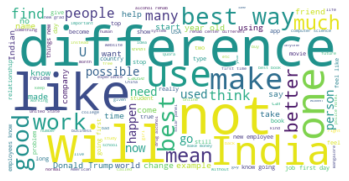

In [ ]:
# Word cloud for non-duplicate question pairs 
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords = stopwords)
#Generation of word cloud
wc.generate(textn_w)
print("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(20, 15))
plt.show()

**Pair plot of features**

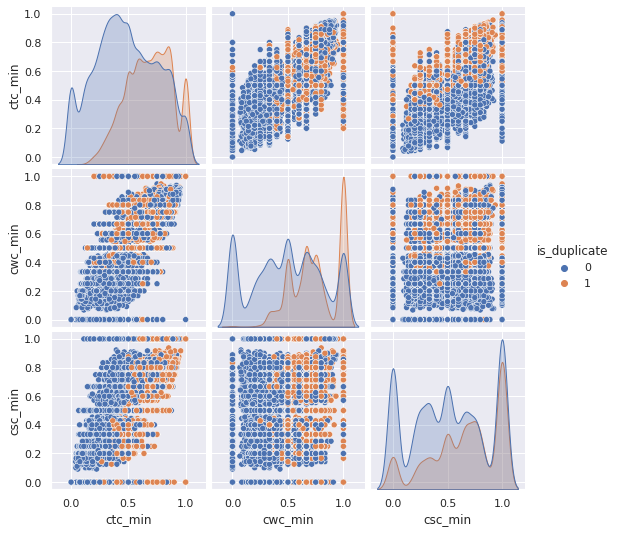

In [ ]:
sns.pairplot(n_df[['ctc_min','cwc_min','csc_min','is_duplicate']], hue='is_duplicate')

**Inferences**


*   Self pairwise plot of ctc_min and csc_min indicates that non-duplicate questions pairs can be distinguised easily based on these two features.
*   Cross pairwise plots indicates that both labels can be distinguised based on these features and we cannot rule out any of the introduced features.



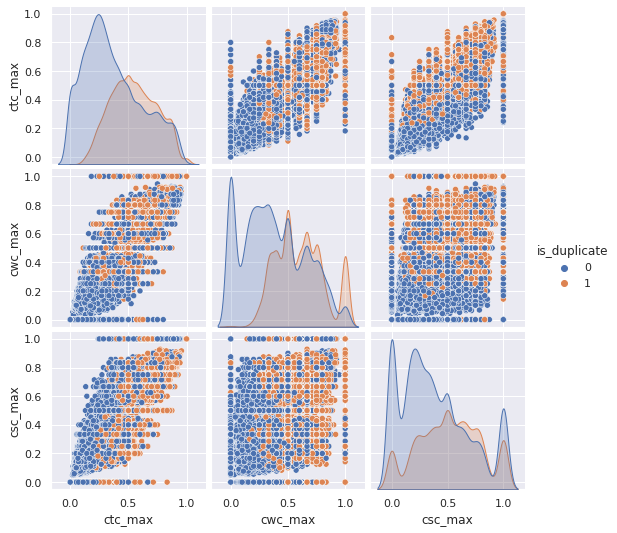

In [ ]:
sns.pairplot(n_df[['ctc_max','cwc_max','csc_max','is_duplicate']], hue='is_duplicate')

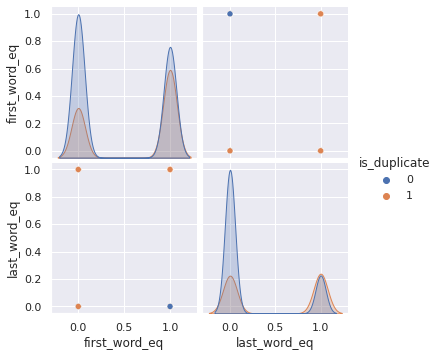

In [ ]:
sns.pairplot(n_df[['first_word_eq','last_word_eq','is_duplicate']], hue='is_duplicate')

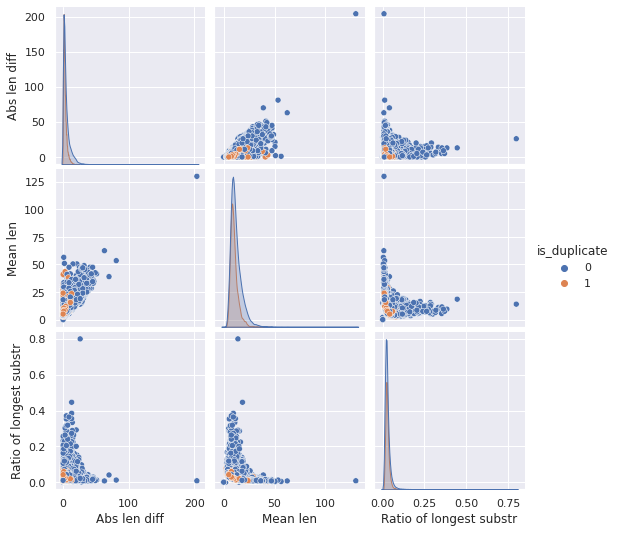

In [ ]:
sns.pairplot(n_df[['Abs len diff','Mean len','Ratio of longest substr','is_duplicate']], hue='is_duplicate')

**Visualization using T-SNE with dimentionality reduction for 11 features**


In [ ]:
# Normalization of features

X = MinMaxScaler().fit_transform(n_df[[ 'ctc_min','cwc_min','csc_min','ctc_max','cwc_max','csc_max' ,'first_word_eq','last_word_eq', 'Abs len diff' , 'Mean len','Ratio of longest substr']])
Y= n_df['is_duplicate'].values

In [ ]:
# Dimentionality reduction of 11 features into 2 dimensions 
tsne2d = TSNE ( n_components=2,
                init='random',
                random_state=101,
                method='barnes_hut',
                n_iter=1000,
                verbose=2,
                angle=0.5).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.047s...
[t-SNE] Computed neighbors for 30000 samples in 4.397s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

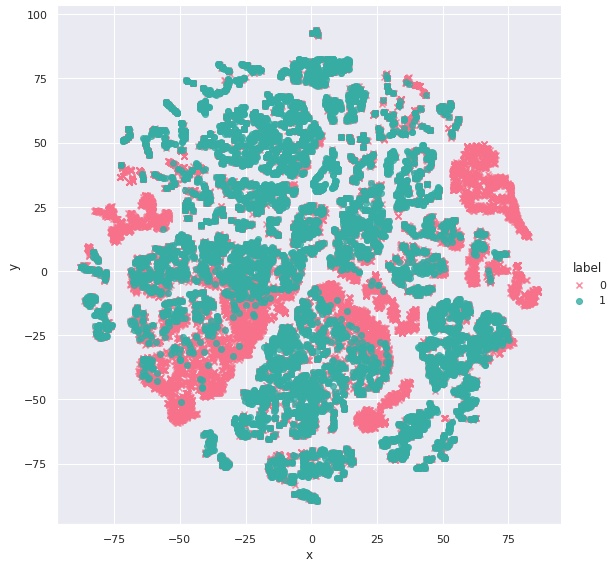

In [ ]:
# 2D Plot of the reduced dimensions 
X_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1],'label':Y})
sns.lmplot(data=X_df,x='x',y='y',hue='label',fit_reg=False,height=8,palette='husl',markers=['x','o'])

# Model Training

In [ ]:
ques_df = n_df[['question1','question2']]
ques_df.head()

,question1,question2
8067,how do i play pokémon go in korea,how do i play pokémon go in china
368101,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...
70497,which is more advisable and better material fo...,what is the best server setup for buddypress
226567,how do i improve logical programming skills,how can i improve my logical skills for progra...
73186,how close we are to see 3rd world war,how close is a world war iii


In [ ]:
#New dataframe of all the features and target
f_df = n_df.drop(columns = ['id','qid1','qid2','question1','question2'])
print(f_df.shape)
f_df.head()

(30000, 19)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,Total words,common_words,word share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,Abs len diff,Mean len,Ratio of longest substr
8067,0,33,33,8,8,16,7,0.44,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0.0,1.0,0.0,8.0,0.029412
368101,0,52,50,11,9,20,6,0.30,0.399992,0.399992,0.999975,0.666656,0.666659,0.545450,0.0,1.0,2.0,10.0,0.019608
70497,0,95,44,17,8,25,2,0.08,0.000000,0.000000,0.499988,0.249997,0.249997,0.124999,0.0,0.0,8.0,12.0,0.022222
226567,1,43,51,7,9,16,6,0.38,0.999975,0.999975,0.666644,0.399992,0.857131,0.666659,0.0,1.0,2.0,8.0,0.022727
73186,1,37,28,9,7,16,4,0.25,0.749981,0.599988,0.333322,0.249994,0.571420,0.444440,0.0,1.0,2.0,8.0,0.068966


In [ ]:
#Bag of Words
ques = list(ques_df['question1']) + list(ques_df['question2'])

#Creating 3000 features in the vocabulary
cv = CountVectorizer(max_features=3000)
q1_a, q2_a = np.vsplit(cv.fit_transform(ques).toarray(),2)

In [ ]:
#Creating master dataframe for model including bag of words features 
 
t_df1 = pd.DataFrame(q1_a, index = ques_df.index)
t_df2 = pd.DataFrame(q2_a, index = ques_df.index)
t_df = pd.concat([t_df1,t_df2], axis = 1)
t_df.shape

(30000, 6000)

In [ ]:
f_df = pd.concat([f_df,t_df],axis=1)

In [ ]:
#Splitting the dataframe into 80-20 train and test split
X_train , X_test , Y_train, Y_test = train_test_split(t_df.iloc[:,0:-1].values, t_df.iloc[:,-1].values, test_size=0.2, random_state = 42)

**Random Forest Classifier**

In [ ]:
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.9995

The introduction of features finally helped to improve the prediction of duplicates immensely.

In [ ]:
confusion_matrix(Y_test,Y_pred)

array([[5997,    0],
       [   3,    0]])

Cost of misclassification is very high, i.e, if user is being told about the duplicate questions which really aren't duplicates then the whole experience is ruined. It is being observed that such error is zero from using the random forest classifier on the dataset.

**XgBoost Classifier**

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,Y_train)
Y_pred1 = xgb.predict(X_test)
accuracy_score(Y_test, Y_pred1)

0.9996666666666667

Accuracy has been slightly improved using the Xgboost Classifier compared to Random forest classifier.

In [ ]:
confusion_matrix(Y_test,Y_pred1)

array([[5997,    0],
       [   2,    1]])

Cost of misclassification is very high, i.e, if user is being told about the duplicate questions which really aren't duplicates then the whole experience is ruined. It is being observed that such error is zero from using the xgboost classifier on the dataset like the random forest classifier.

However, Xgboost classifier yields the correct wrong duplicates too alongwith more refined error and hence it is being preferred over random forest classifier for this dataset.